- 
github 출력 안보이는 경우 [nbviewer](https://nbviewer.org/github/nidolight/AIffel_GoingDeeper/blob/main/%5BG-01%5DResNet34_50/%5BG-01%5DResNet34_50.ipynb)에서 확인

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

## 1) ResNet 기본 블록 구성하기
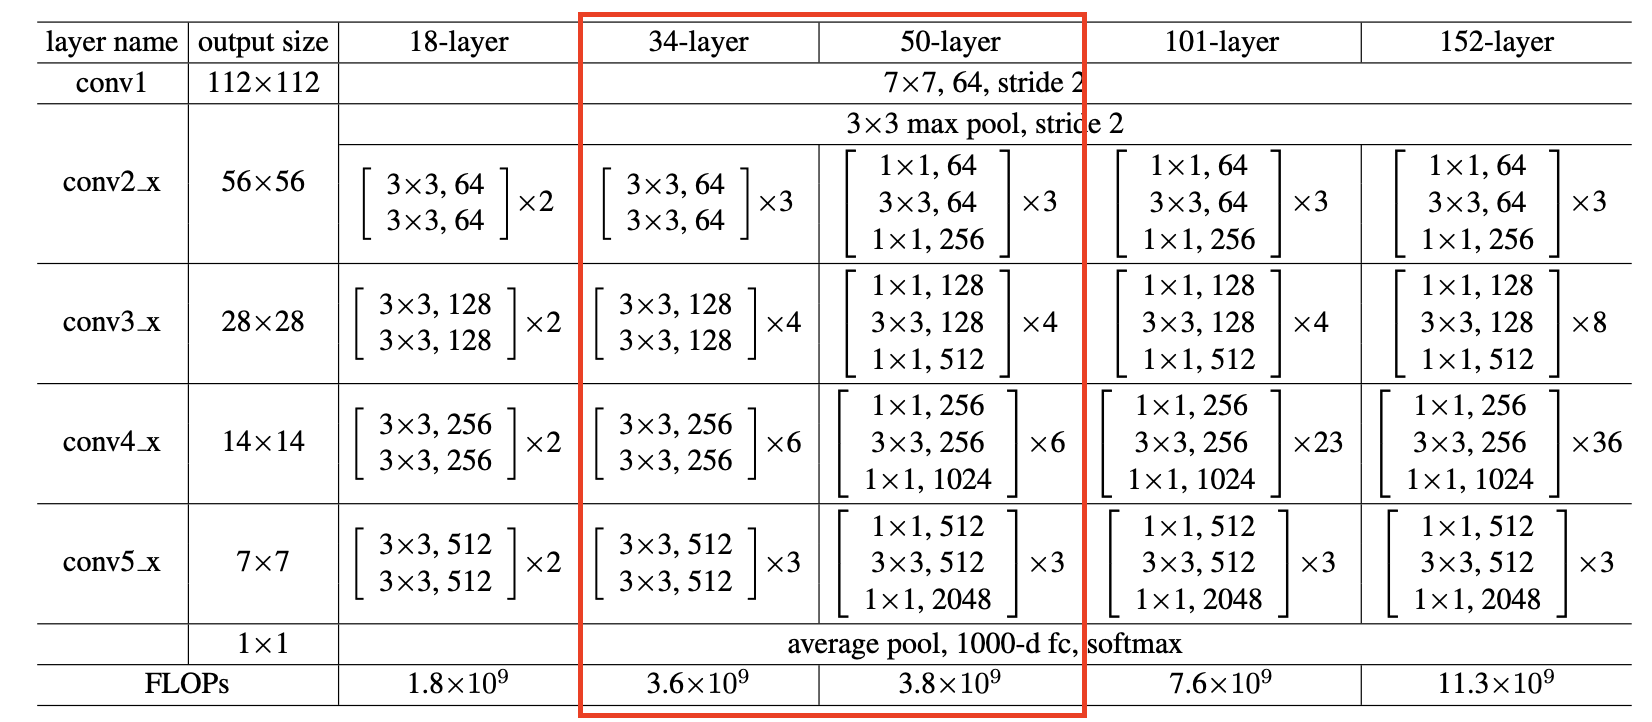

2015년 ResNet을 소개한 [논문](https://arxiv.org/pdf/1512.03385.pdf)에서 ResNet-18, 34, 50, 101, 152의 다섯 가지 네트워크를 소개합니다. 이 중 ResNet-34와 50을 구현해 보겠습니다. <br>각 네트워크를 하나씩 구현하는 방법도 있지만 매우 수고스럽고 변경사항이 생기면 모두 고쳐줘야 하는 불편함이 생기게 됩니다. <br>따라서 ResNet의 기본 구조인 Residual 블록을 먼저 구현하겠습니다.

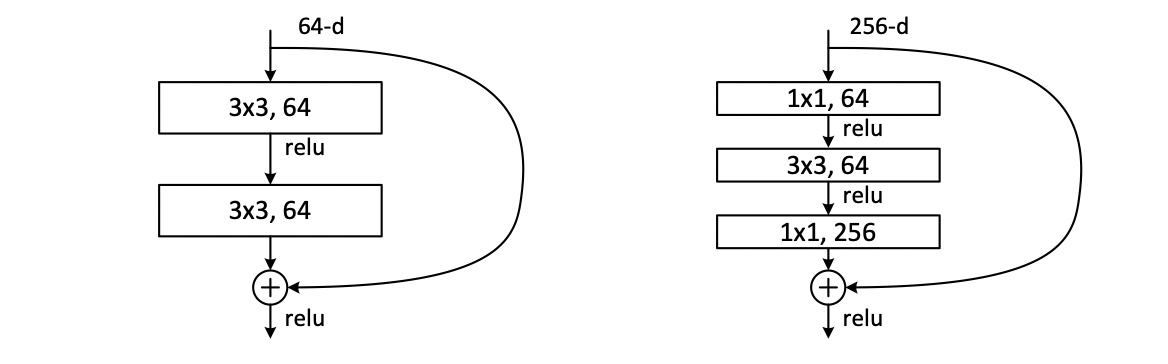

In [2]:
# function for building Residual Block
def build_Residual_block(x, filters=64, kernel_size=3, i=0, j=0, is_50=False):
    y = layers.Conv2D(filters, kernel_size=(1 if is_50 else kernel_size),
                      padding='same',
                      strides=(1 if i==0 and j==0 else 2 if j==0 else 1))(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filters, kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)
    
    if is_50:
        y = layers.Activation('relu')(y)
        y = layers.Conv2D(filters=filters*4,
                          kernel_size=1,
                          padding='same')(y)
        y = layers.BatchNormalization()(y)
        
        if j==0:
            x = layers.Conv2D(filters=filters*4, 
                              kernel_size=1, 
                              padding='same',
                              strides=(1 if i==0 and j==0 else 2))(x)
            x = layers.BatchNormalization()(x)
    else:
        if i>0 and j==0:
            x = layers.Conv2D(filters, kernel_size=1, padding='same',
                              strides=2)(x)
            x = layers.BatchNormalization()(x)
 
    y = layers.Add()([x,y])
    y = layers.Activation('relu')(y)
        
    return y

In [3]:
ResNet_input_layer = keras.layers.Input(shape=(32,32,64))   # 입력 레이어 생성

ResNet34_block_output = build_Residual_block(ResNet_input_layer,is_50=False)    # Residual 블록 생성
ResNet50_block_output = build_Residual_block(ResNet_input_layer,is_50=True)

In [4]:
# ResNet50 블록 1개짜리 model 생성
block34 = keras.Model(inputs=ResNet_input_layer, outputs=ResNet34_block_output)  
block34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   36928       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

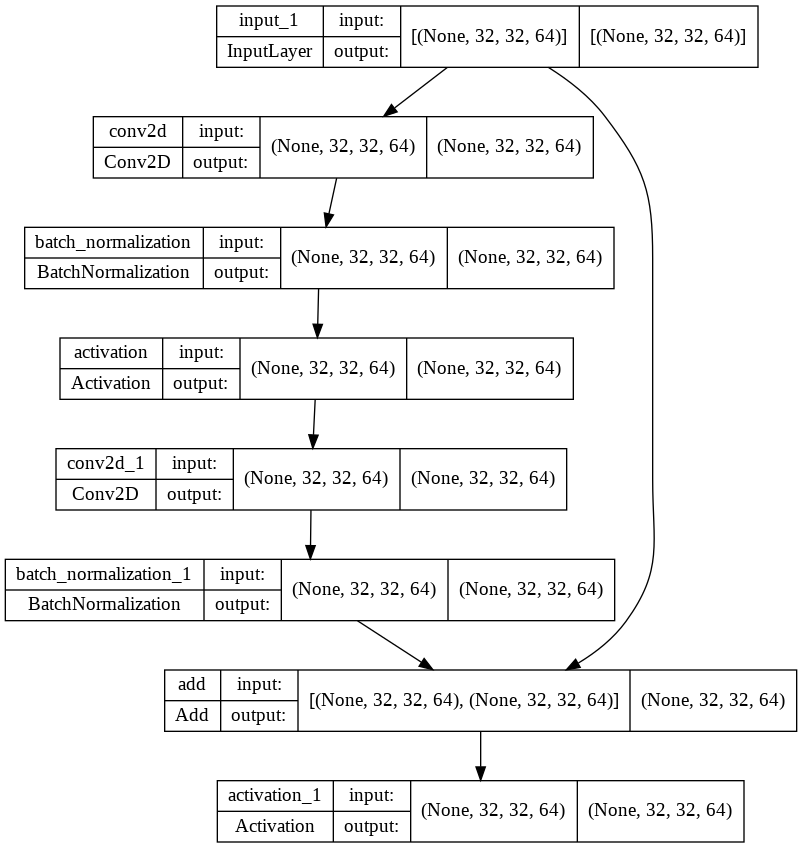

In [5]:
plot_model(block34, to_file='residual34_block.png', show_shapes=True, show_layer_names=True)

In [6]:
# ResNet50 블록 1개짜리 model 생성
block50 = keras.Model(inputs=ResNet_input_layer, outputs=ResNet50_block_output)  
block50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 64)   4160        ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 32, 32, 64)  256         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                            

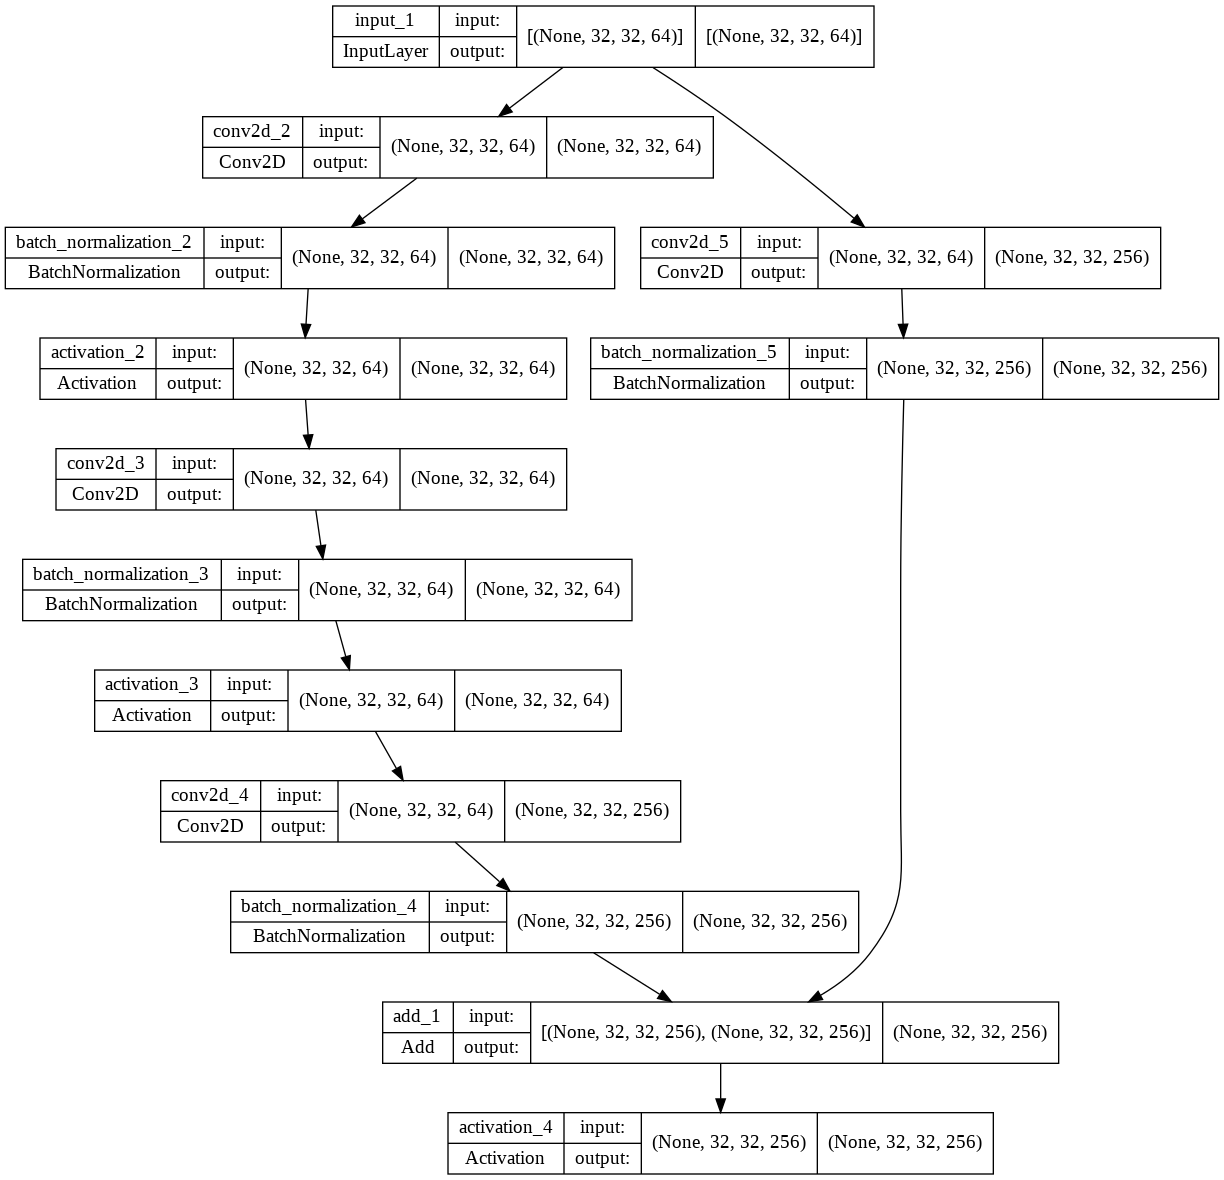

In [7]:
plot_model(block50, to_file='residual50_block.png', show_shapes=True, show_layer_names=True)

## 2) ResNet-34, ResNet-50 Complete Model
블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. <br>
ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 `build_resnet()`를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있습니다.

In [8]:
def build_resnet(input_shape=(32, 32, 3),
                 num_blocks_list=[3, 4, 6, 3],
                 channel_list=[64,128,256,512],
                 num_classes = 10,
                 is_50=False):
    
    assert len(num_blocks_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)    # input layer를 만들어둡니다.
    
    output = keras.layers.Conv2D(kernel_size=7,
                                 strides=2,
                                 filters=64,
                                 padding="same")(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(pool_size=2,
                                       strides=2,
                                       padding="same")(output)
    
    for i in range(len(num_blocks_list)):
        for j in range(num_blocks_list[i]):
            output = build_Residual_block(output,filters=channel_list[i],i=i,j=j,is_50=is_50)

    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid')(output)#sigmoid사용
    
    
    model = keras.Model(
            inputs=input_layer, 
            outputs=output,
            name=('resnet50' if is_50 else 'resnet34')
    )

    return model

### resnet34

In [9]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False)
resnet_34.summary()

Model: "resnet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_6[0]

### resnet50

In [10]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 16, 16, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_42 (BatchN  (None, 16, 16, 64)  256         ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_38 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_42[0

## 3) 일반 네트워크(plain network) 만들기
PLain network도 resnet을 구현한 것과 마찬가지로 블록 단위를 만들어 주어 구현합니다.<br>
Plain Block은 앞서 구현한 Residual Block에서 shortcut을 add해주는 부분(skip connection)만 빼면 쉽게 만들 수 있습니다.

In [11]:
# function for building Residual Block
def build_Plain_block(x, filters=64, kernel_size=3, i=0, j=0, is_50=False):
    y = layers.Conv2D(filters, kernel_size=(1 if is_50 else kernel_size),
                      padding='same',
                      strides=(1 if i==0 and j==0 else 2 if j==0 else 1))(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filters, kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)
    
    if is_50:
        y = layers.Activation('relu')(y)
        y = layers.Conv2D(filters=filters*4,
                          kernel_size=1,
                          padding='same')(y)
        y = layers.BatchNormalization()(y)
        
    #     if j==0:
    #         x = layers.Conv2D(filters=filters*4, 
    #                           kernel_size=1, 
    #                           padding='same',
    #                           strides=(1 if i==0 and j==0 else 2))(x)
    #         x = layers.BatchNormalization()(x)
    # else:
    #     if i>0 and j==0:
    #         x = layers.Conv2D(filters, kernel_size=1, padding='same',
    #                           strides=2)(x)
    #         x = layers.BatchNormalization()(x)
 
    # y = layers.Add()([x,y])
    y = layers.Activation('relu')(y)
        
    return y

Plain network도 ResNet과 마찬가지로 34, 50레이어를 각각 만들어줍니다.

In [12]:
def build_plainnet(input_shape=(32, 32, 3),
                 num_blocks_list=[3, 4, 6, 3],
                 channel_list=[64,128,256,512],
                 num_classes=10,
                 is_50=False):
    
    assert len(num_blocks_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape) 
    
    output = keras.layers.Conv2D(kernel_size=7,
                                 strides=2,
                                 filters=64,
                                 padding="same")(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(pool_size=2,
                                       strides=2,
                                       padding="same")(output)
    
    for i in range(len(num_blocks_list)):
        for j in range(num_blocks_list[i]):
            #이 부분만 수정 Residual_block -> Plain_block
            output = build_Plain_block(output,filters=channel_list[i],i=i,j=j,is_50=is_50)

    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid')(output)
    
    
    model = keras.Model(
            inputs=input_layer, 
            outputs=output,
            name=('plainnet50' if is_50 else 'plainnet34')
    )

    return model

### plainnet34

In [13]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False)
plain_34.summary()

Model: "plainnet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_95 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_95 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_87 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_96 (Conv2D)          (None, 56, 56, 64)        3

### plainnet50

In [14]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "plainnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_128 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_128 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_120 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_129 (Conv2D)         (None, 56, 56, 64)        4

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [16]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [17]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


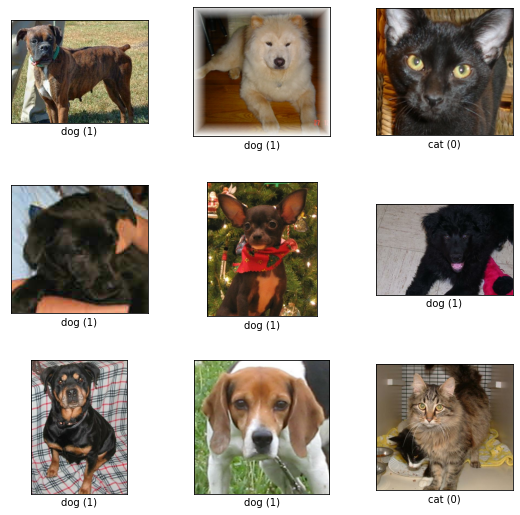

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

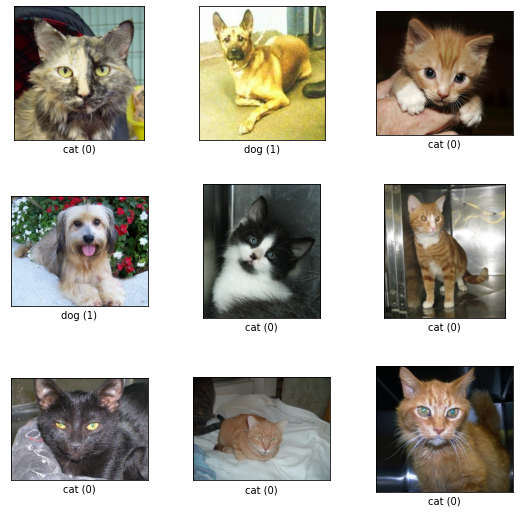

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

In [20]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [21]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [22]:
BATCH_SIZE = 32
EPOCH = 10

In [23]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [24]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False)

In [25]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 113s 145ms/step - loss: 0.6765 - accuracy: 0.6183 - val_loss: 0.8586 - val_accuracy: 0.5032
Epoch 2/10
581/581 [==============================] - 77s 132ms/step - loss: 0.6048 - accuracy: 0.6777 - val_loss: 1.6437 - val_accuracy: 0.5152
Epoch 3/10
581/581 [==============================] - 77s 132ms/step - loss: 0.5265 - accuracy: 0.7437 - val_loss: 0.5408 - val_accuracy: 0.7294
Epoch 4/10
581/581 [==============================] - 77s 132ms/step - loss: 0.4715 - accuracy: 0.7809 - val_loss: 0.8376 - val_accuracy: 0.6002
Epoch 5/10
581/581 [==============================] - 77s 132ms/step - loss: 0.4103 - accuracy: 0.8107 - val_loss: 2.0635 - val_accuracy: 0.5784
Epoch 6/10
581/581 [==============================] - 77s 132ms/step - loss: 0.3456 - accuracy: 0.8480 - val_loss: 20.5059 - val_accuracy: 0.6107
Epoch 7/10
581/581 [==============================] - 77s 132ms/step - loss: 0.2859 - accuracy: 0.8798 - val_loss: 0.8369 - val_

In [26]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('history_resnet_34.csv', index=False)

In [27]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True)

In [28]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 135s 203ms/step - loss: 0.6876 - accuracy: 0.6255 - val_loss: 0.6929 - val_accuracy: 0.5420
Epoch 2/10
581/581 [==============================] - 117s 201ms/step - loss: 0.6000 - accuracy: 0.6835 - val_loss: 3.4093 - val_accuracy: 0.4468
Epoch 3/10
581/581 [==============================] - 117s 202ms/step - loss: 0.5103 - accuracy: 0.7505 - val_loss: 0.9805 - val_accuracy: 0.6429
Epoch 4/10
581/581 [==============================] - 117s 202ms/step - loss: 0.4364 - accuracy: 0.7973 - val_loss: 1.1890 - val_accuracy: 0.5532
Epoch 5/10
581/581 [==============================] - 117s 202ms/step - loss: 0.3771 - accuracy: 0.8336 - val_loss: 1.0713 - val_accuracy: 0.6823
Epoch 6/10
581/581 [==============================] - 117s 202ms/step - loss: 0.3136 - accuracy: 0.8643 - val_loss: 1.0989 - val_accuracy: 0.5768
Epoch 7/10
581/581 [==============================] - 117s 202ms/step - loss: 0.2703 - accuracy: 0.8857 - val_loss: 0.3314 -

In [29]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })
df_resnet_50.to_csv('history_resnet_50.csv', index=False)

In [30]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False)

In [31]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 90s 130ms/step - loss: 0.6972 - accuracy: 0.5198 - val_loss: 1.1780 - val_accuracy: 0.5129
Epoch 2/10
581/581 [==============================] - 75s 129ms/step - loss: 0.6719 - accuracy: 0.5602 - val_loss: 0.6796 - val_accuracy: 0.5123
Epoch 3/10
581/581 [==============================] - 75s 129ms/step - loss: 0.6610 - accuracy: 0.5830 - val_loss: 0.6977 - val_accuracy: 0.5182
Epoch 4/10
581/581 [==============================] - 75s 130ms/step - loss: 0.6539 - accuracy: 0.6043 - val_loss: 5.1541 - val_accuracy: 0.5170
Epoch 5/10
581/581 [==============================] - 75s 129ms/step - loss: 0.6463 - accuracy: 0.6105 - val_loss: 0.8693 - val_accuracy: 0.5481
Epoch 6/10
581/581 [==============================] - 76s 131ms/step - loss: 0.6337 - accuracy: 0.6301 - val_loss: 1.5028 - val_accuracy: 0.5500
Epoch 7/10
581/581 [==============================] - 76s 131ms/step - loss: 0.6153 - accuracy: 0.6580 - val_loss: 0.6617 - val_ac

In [32]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('history_plain_34.csv', index=False)

In [33]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True)

In [34]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 119s 177ms/step - loss: 0.7062 - accuracy: 0.4965 - val_loss: 0.6949 - val_accuracy: 0.4843
Epoch 2/10
581/581 [==============================] - 102s 176ms/step - loss: 0.6903 - accuracy: 0.5296 - val_loss: 0.7247 - val_accuracy: 0.5335
Epoch 3/10
581/581 [==============================] - 102s 176ms/step - loss: 0.6906 - accuracy: 0.5361 - val_loss: 0.6925 - val_accuracy: 0.5024
Epoch 4/10
581/581 [==============================] - 102s 176ms/step - loss: 0.6848 - accuracy: 0.5553 - val_loss: 0.7818 - val_accuracy: 0.4924
Epoch 5/10
581/581 [==============================] - 103s 177ms/step - loss: 0.6729 - accuracy: 0.5906 - val_loss: 0.7073 - val_accuracy: 0.5364
Epoch 6/10
581/581 [==============================] - 103s 178ms/step - loss: 0.6865 - accuracy: 0.5543 - val_loss: 0.7265 - val_accuracy: 0.5183
Epoch 7/10
581/581 [==============================] - 103s 178ms/step - loss: 0.6836 - accuracy: 0.5559 - val_loss: 26.5285 

In [35]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('history_plain_50.csv', index=False)

In [36]:
history_resnet_34 = pd.read_csv('history_resnet_34.csv')
history_resnet_50 = pd.read_csv('history_resnet_50.csv')
history_plain_34 = pd.read_csv('history_plain_34.csv')
history_plain_50 = pd.read_csv('history_plain_50.csv')

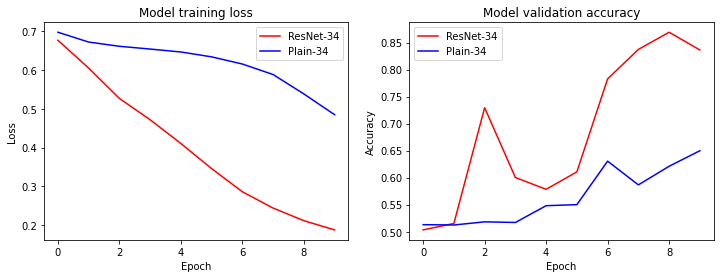

In [37]:
# ResNet-34 vs Plain-34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

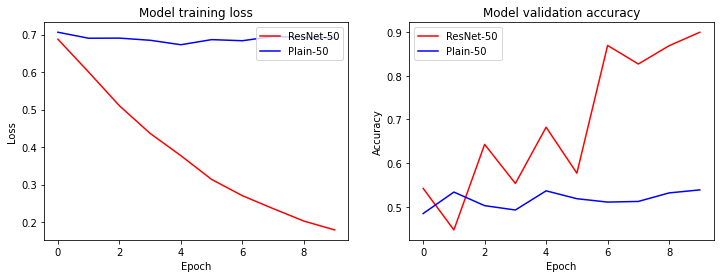

In [38]:
# ResNet-50 vs Plain-50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_50['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_50['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

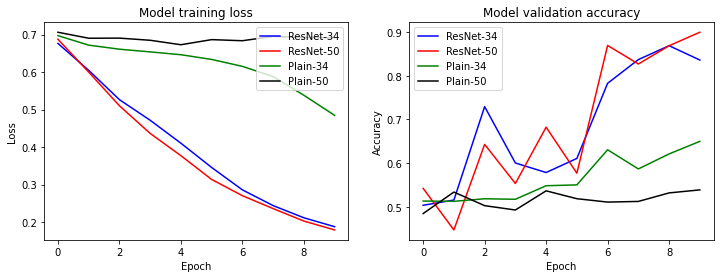

In [39]:
# 전체 비교
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'g')
plt.plot(history_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'g')
plt.plot(history_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

In [40]:
# validation accuracy 비교표
accuracy = {
    'Plain': [round(history_plain_34['val_acc'].mean(), 4),
              round(history_plain_50['val_acc'].mean(), 4)],
    'ResNet': [round(history_resnet_34['val_acc'].mean(), 4), 
               round(history_resnet_50['val_acc'].mean(), 4)]
}

df_acc = pd.DataFrame(accuracy, index=['34 layers', '50 layers'])
df_acc

,Plain,ResNet
34 layers,0.5646,0.6863
50 layers,0.5160,0.6910


- 그래프를 통해 resnet이 plainnet보다 Loss값이 빠르게 낮아지고 Accuracy 또한 빠르게 증가하는 것을 확인할 수 있습니다.
- validation accuracy 또한 resnet이 plainnet보다 높은 결과를 보여줍니다.

---
## 회고
going deeper 시간을 통해 이전에 깊게 알아보지 못했던 resnet에 대한 구조를 알게 되었습니다. 논문을 토대로 논문과 비슷한 결과가 나와주었는데 쉽지 않은 것 같습니다. 시간이 오래 걸려 10 EPOCH 밖에 테스트하지 못했는데, 추후 EPOCH를 늘리고 다른 데이터셋에 대해서의 결과도 확인해 보고 싶습니다.